In [1]:
import numpy as np
import pandas as pd
from constrained_k_means import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import seaborn as sns
import scipy as sp
import multiprocessing as mp
from sklearn.manifold import MDS
import time
from tqdm import tqdm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA



In [2]:
def PCA_2d_visualize_clusters(cell_id: int, 
                     ch: int,
                     chr_index: np.array([]),
                    ckmeans_clusters,
                    ckmeans_clusters_corrected): 
    
    cell_ = pd.read_csv("data/embryo_data.csv")
    cell_ = cell_.loc[cell_.cell_index == cell_id]
    cell_chr = cell_.loc[cell_.chr == ch]
    mat_idx = np.where((cell_.chr == ch) & (cell_.hap1_reads > 0))
    pat_idx = np.where((cell_.chr == ch) & (cell_.hap2_reads > 0))
   
    # for visualization purposes, let's project the data into 2d
    pca = PCA(n_components=2, svd_solver='full')

  
    igs_clusters = cell_.iloc[chr_index]['cluster']
    
    kmeans = KMeans(n_clusters=2, random_state=100, init = np.array([[131.0144, 118.8255 , 16.3317],
                                                             [128.248, 116.6465 , 24.5699]])
                   ).fit(np.array(cell_chr[['x_um_abs','y_um_abs','z_um_abs']]))
    kmeans_clusters = kmeans.labels_
  
    
    cell_ = cell_[['x_um_abs','y_um_abs','z_um_abs']]
    reduced_cell = pca.fit_transform(np.array(cell_))
    reduced_cell_chr =reduced_cell[chr_index]

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(221)
    ax.scatter(reduced_cell[:,0], reduced_cell[:,1],c = 'gray', alpha = 0.4, s = 10)
    ax.scatter(reduced_cell[mat_idx,0], reduced_cell[mat_idx,1],c = 'red', alpha = 0.4, s = 30, marker = 'x')
    ax.scatter(reduced_cell[pat_idx,0], reduced_cell[pat_idx,1],c = 'blue', alpha = 0.4, s = 30, marker = 'x')
    ax.scatter(reduced_cell_chr[:,0], reduced_cell_chr[:,1],c = igs_clusters, alpha = 0.8, cmap = 'bwr', s = 20)
    ax.set_title("IGS clusters: cell {}, chr {}".format(cell_id, ch), fontsize = 18)
    
    ax = fig.add_subplot(222)
    ax.scatter(reduced_cell[:,0], reduced_cell[:,1],c = 'gray', alpha = 0.4, s = 10)
    ax.scatter(reduced_cell_chr[:,0], reduced_cell_chr[:,1],c = kmeans_clusters, alpha = 0.8, cmap = 'bwr', s = 20)
    ax.set_title("kmeans: cell {}, chr {}".format(cell_id, ch), fontsize = 18)
    
    ax = fig.add_subplot(223)
    ax.scatter(reduced_cell[:,0], reduced_cell[:,1],c = 'gray', alpha = 0.4, s = 10)
    ax.scatter(reduced_cell_chr[:,0], reduced_cell_chr[:,1],c = ckmeans_clusters, alpha = 0.8, cmap = 'bwr', s = 20)
    ax.set_title("ours: cell {}, chr {}".format(cell_id, ch), fontsize = 18)
    
    ax = fig.add_subplot(224)
    ax.scatter(reduced_cell[:,0], reduced_cell[:,1],c = 'gray', alpha = 0.4, s = 10)
    ax.scatter(reduced_cell_chr[:,0], reduced_cell_chr[:,1],c = ckmeans_clusters_corrected, alpha = 0.8, cmap = 'bwr', s = 20)
    ax.set_title("ours after variance correction: cell {}, chr {}".format(cell_id, ch), fontsize = 18)
 
    
    plt.tight_layout()
    plt.show()
    
def PCA_2d_visualize_constraints(cell_id: int, 
                     ch: int,
                    constraints: np.array([])):
    cell_ = pd.read_csv("data/embryo_data.csv")
    cell_ = cell_.loc[cell_.cell_index == cell_id]
    fig = plt.figure(figsize = (6,6))
    chr_index = np.where(cell_.chr==ch)
    mat_index = np.where((cell_.hap1_reads>0) & (cell_.chr == ch))[0]
    pat_index = np.where((cell_.hap2_reads>0) & (cell_.chr == ch))[0]
   
    # for visualization purposes, let's project the data into 2d
    pca = PCA(n_components=2, svd_solver='full')

    
    cell_ = cell_[['x_um_abs','y_um_abs','z_um_abs']]
    reduced_cell = pca.fit_transform(np.array(cell_))
    reduced_cell_chr =reduced_cell[chr_index]
    reduced_mat = reduced_cell[mat_index]
    reduced_pat = reduced_cell[pat_index]

    ax = fig.add_subplot()
    ax.scatter(reduced_cell[:,0], reduced_cell[:,1],c = 'gray', alpha = 0.4, s = 10, label = "context chromosome")
    ax.scatter(reduced_cell_chr[:,0], reduced_cell_chr[:,1],c = 'black', alpha = 0.8, s = 20, label = "chromosome of interest")
    ax.scatter(reduced_mat[:,0], reduced_mat[:,1], marker = "x", c = "red", s = 70, label = "maternal SNP")
    ax.scatter(reduced_pat[:,0], reduced_pat[:,1], marker = "x", c = "blue", s = 70, label = "paternal SNP")
    
    n = constraints.shape[0]
    for i in range(0,n):
        for j in range(i,n):
            if constraints[i,j] > 0:
                ax.plot(reduced_cell_chr[(i,j),0], reduced_cell_chr[(i,j),1], 'g-', alpha = 0.5)
                ax.text(reduced_cell_chr[i,0], reduced_cell_chr[i,1] + 0.1, i)
                ax.text(reduced_cell_chr[j,0], reduced_cell_chr[j,1] + 0.1, j)
            if constraints[i,j] < 0:
                ax.plot(reduced_cell_chr[(i,j),0], reduced_cell_chr[(i,j),1], 'r--',alpha = 0.5)
                ax.text(reduced_cell_chr[i,0], reduced_cell_chr[i,1] + 0.1, i)
                ax.text(reduced_cell_chr[j,0], reduced_cell_chr[j,1] + 0.1, j)

    plt.title("cell {} chromosome {}".format(cell_id, ch))
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()

    
"""data is nx3, constraints is nxn
the first chr_n rows of data is referring to the chromosome of interest"""
def visualize_constraints(data, constraints, alpha_in = 0.01, chr_n = None, title = None):
    n = constraints.shape[0]
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(projection = '3d')
    
    ax.scatter( data[:,0],  data[:,1],  data[:,2], c = 'gray', alpha = 0.5, s = 10)
    if chr_n is not None: #for plotting the first chr_n reads in a different color
        ax.scatter(data[:chr_n,0], data[:chr_n,1], data[:chr_n,2], c = 'black', alpha = 1, s = 10, label = "chr of interest")

    for i in range(0, n):
        for j in range(i+1,n):
            if constraints[i,j] > 0:
                ax.plot(data[(i,j),0], data[(i,j),1], data[(i,j),2], 'g-', alpha = alpha_in )
            if constraints[i,j] < 0:
                ax.plot(data[(i,j),0], data[(i,j),1], data[(i,j),2], 'r--', alpha = alpha_in)
    ax.legend()
    ax.set_title("constraints " + title)


    

In [26]:
embryo = pd.read_csv("data/embryo_data.csv")
np.random.seed(100)

cell_index= 7
chr_ = 7

cell_df = embryo.loc[embryo.cell_index==cell_index]
chr_index = np.where(cell_df.chr==chr_)
not_chr_index = np.where(cell_df.chr!=chr_)
not_chr_index_sampled = np.random.choice(not_chr_index[0], size = max(2*len(chr_index[0]), 100))
cell_chr_df = cell_df.iloc[chr_index]
cell_not_chr_df = cell_df.iloc[not_chr_index_sampled]

#this is the data that is getting clustered
X=np.array(cell_chr_df[['x_um_abs','y_um_abs','z_um_abs']]) #this is the data that will be clustered into 2 clusters
not_X =  np.array(cell_not_chr_df[['x_um_abs','y_um_abs','z_um_abs']])
data = np.vstack((X,not_X))
chr_n = X.shape[0]
not_chr_n = not_X.shape[0]
n = data.shape[0]

#positive constraints among the "cell_not_chr" reads, and negative constraint b/w different chromosomes
constraints = np.zeros((n, n))
constraints[-not_chr_n:, -not_chr_n:] = 10
constraints[:chr_n, -not_chr_n:] = -10
constraints[:chr_n, :chr_n] = get_constraint_matrix(cell_chr_df)

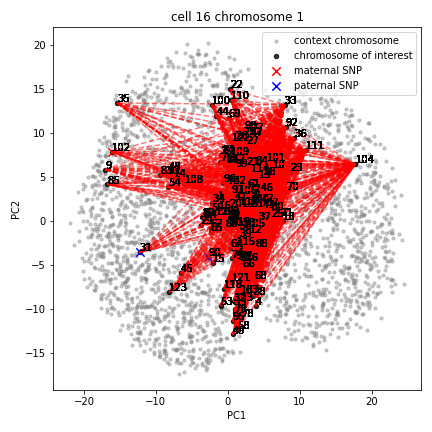

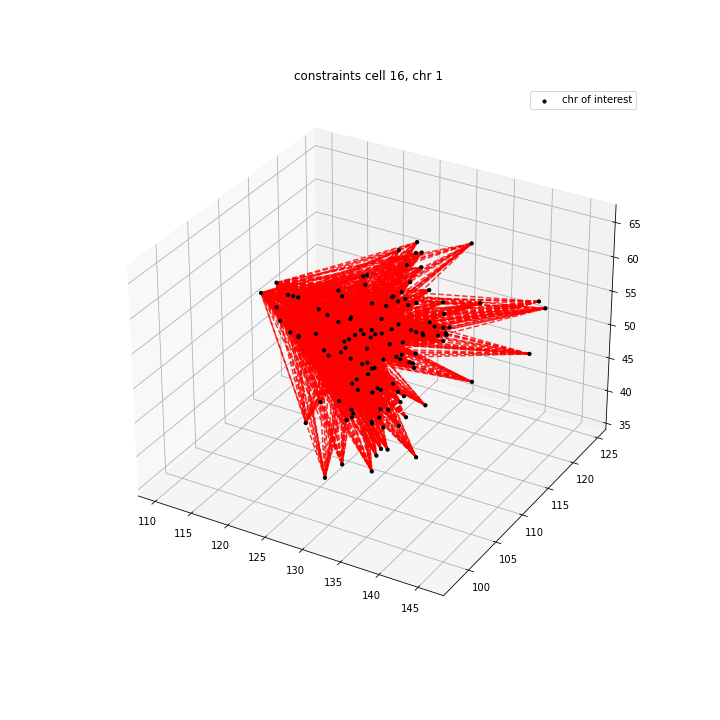

In [21]:
PCA_2d_visualize_constraints(cell_index, chr_, constraints[:chr_n, :chr_n])
visualize_constraints(data[:chr_n, :chr_n], constraints[:chr_n, :chr_n], alpha_in = 0.8, chr_n=chr_n, title = 'cell {}, chr {}'.format(cell_index, chr_))

  ---------  
num_components =  2
cluster separation penalty =  10
cluster separation radius threshold =  1
  ---------  
given negative constraints: initializing means with seed 0
[[ 98.5306 124.6394  30.6   ]
 [112.1809 125.8311  40.2   ]]


  0%|                                                                                                                   | 0/40 [00:00<?, ?it/s]

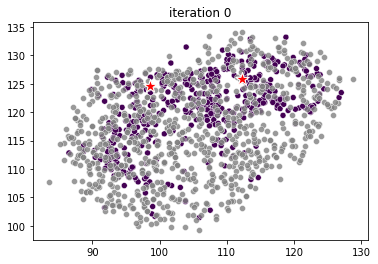

  2%|██▋                                                                                                        | 1/40 [00:25<16:18, 25.10s/it]

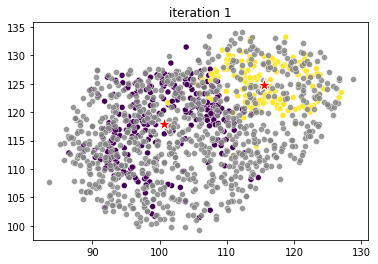

  5%|█████▎                                                                                                     | 2/40 [00:50<15:59, 25.24s/it]

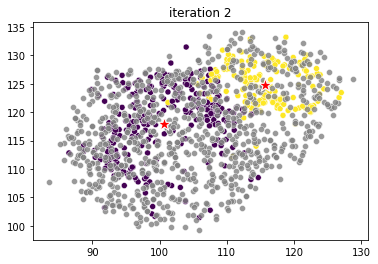

  5%|█████▎                                                                                                     | 2/40 [01:15<23:56, 37.80s/it]

converged


given negative constraints: initializing means with seed 100
[[ 98.7473 124.531   30.6   ]
 [110.8808 129.8395  51.    ]]


  0%|                                                                                                                   | 0/40 [00:00<?, ?it/s]

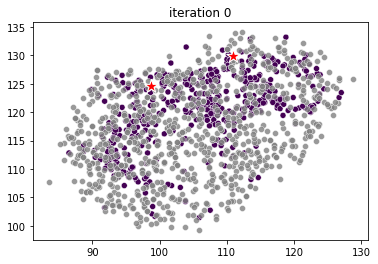

  2%|██▋                                                                                                        | 1/40 [00:25<16:46, 25.81s/it]

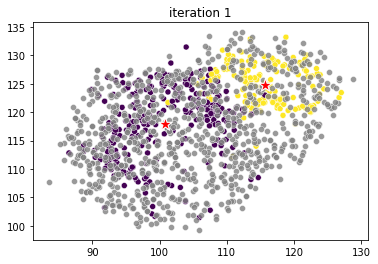

  5%|█████▎                                                                                                     | 2/40 [00:51<16:09, 25.52s/it]

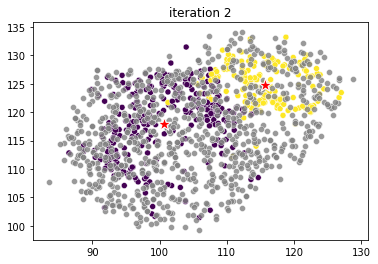

  5%|█████▎                                                                                                     | 2/40 [01:16<24:10, 38.18s/it]

converged


given negative constraints: initializing means with seed 1000
[[114.1309 126.0477  35.8   ]
 [110.0142 118.2476  21.    ]]


  0%|                                                                                                                   | 0/40 [00:00<?, ?it/s]

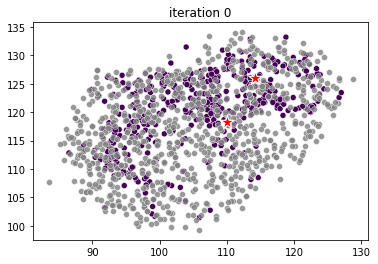

  2%|██▋                                                                                                        | 1/40 [00:25<16:19, 25.11s/it]

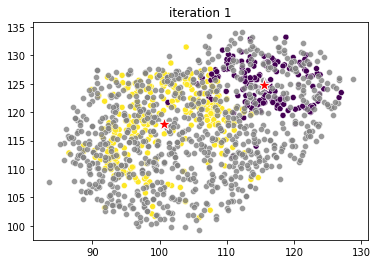

  5%|█████▎                                                                                                     | 2/40 [00:50<16:05, 25.40s/it]

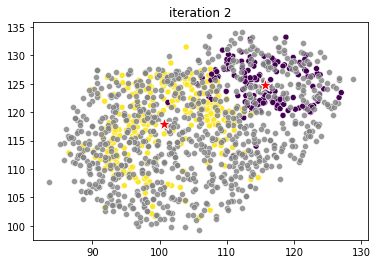

  5%|█████▎                                                                                                     | 2/40 [01:15<24:01, 37.94s/it]

converged


losses of the different runs:  [19265.31 19265.31 19265.31]


In [27]:
%matplotlib inline
id_of_interest = np.array([]) #np.where((labels == 2) & (data[:,2] < 48))[0] #np.where((data[:,0] <110) & (data[:,2] > 40) & (data[:,1] > 100))[0]
pckmeans = PCKMeans(2, constraints, data, chr_n = chr_n, separation_penalty = 10, radius_threshold = 1)

# labels = pckmeans.fit(seed = 100, id_of_interest = id_of_interest ,visualize = True)
labels = pckmeans.fit_and_get_total_loss([],visualize = True)



/home/parmida/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


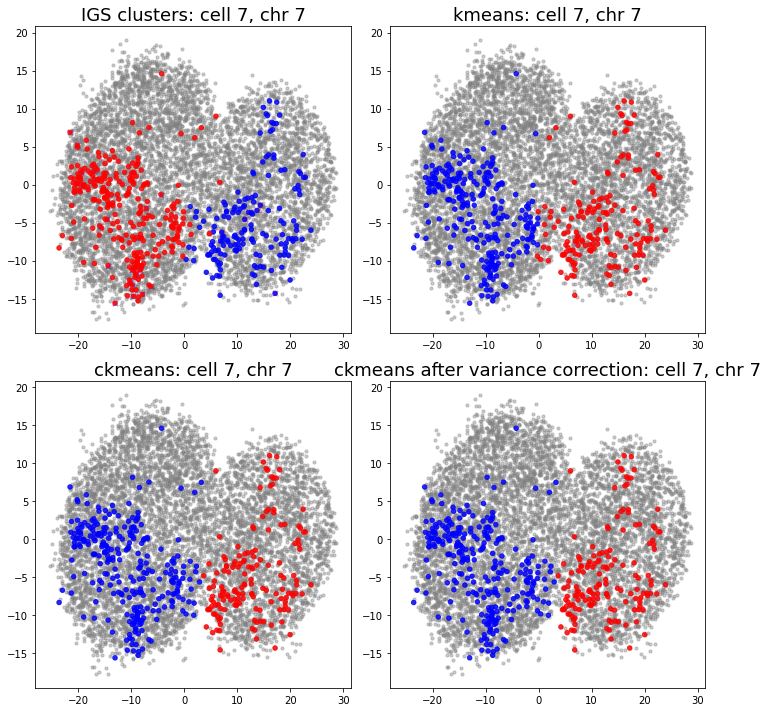

In [28]:
%matplotlib inline
labels = pckmeans.labels
chr_labels = labels[:chr_n]
gmm_labels = GaussianMixture(n_components=2, random_state=0).fit(X).predict(X)
PCA_2d_visualize_clusters(cell_index, chr_, chr_index, chr_labels, pckmeans.likelihood_correction()[:chr_n] )  # pckmeans.likelihood_correction()[:chr_n]



mat:  [1. 1. 1. 1. 1. 1.] pat:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


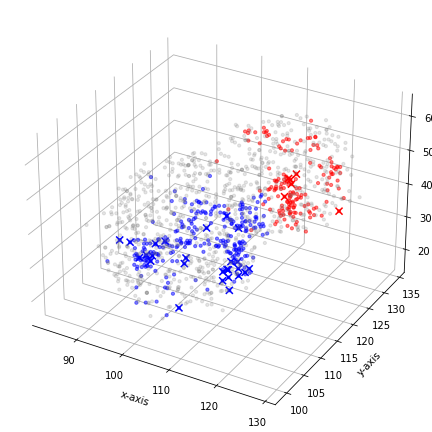

In [31]:
def interactive_plot(cell_,cell_chr, chr_num, labels):
    %matplotlib widget
    # creating figure
    fig = plt.figure(figsize = (6,6))
    ax = Axes3D(fig,auto_add_to_figure=False)
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    fig.add_axes(ax)
    
    this_chr = cell_[cell_[:,-1] == chr_num]
    mat_idx = np.where((this_chr[:,-3] > 0))
    pat_idx = np.where((this_chr[:,-2] > 0))
#     mat_idx = np.where((cell_[:,-3] > 0) & (cell_[:,-1] == chr_num))
#     pat_idx = np.where((cell_[:,-2] > 0) & (cell_[:,-1] == chr_num))
    print("mat: ", labels[mat_idx], "pat: ", labels[pat_idx])

#     ax.scatter(cell_chr[:cell_chr.shape[0],0], cell_chr[:cell_chr.shape[0],1], cell_chr[:cell_chr.shape[0],2], c = labels[:cell_chr.shape[0]],s = 10, alpha = 1)
    ax.scatter(cell_chr[chr_n:,0], cell_chr[chr_n:,1], cell_chr[chr_n:,2], c = 'gray',s = 10, alpha = 0.2)
    ax.scatter(cell_chr[:chr_n,0], cell_chr[:chr_n,1], cell_chr[:chr_n,2], c = labels[:chr_n],s = 10, alpha = 0.5, cmap = 'bwr')
    ax.scatter(this_chr[mat_idx,0], this_chr[mat_idx,1], this_chr[mat_idx,2], c = 'red',s = 50, alpha = 1, marker = 'x',cmap = 'set1')
    ax.scatter(this_chr[pat_idx,0], this_chr[pat_idx,1], this_chr[pat_idx,2], c = 'blue',s = 50, alpha = 1, marker = 'x',cmap = 'set1')

#     means = pckmeans.get_cluster_centers()
#     ax.scatter(means[:,0], means[:,1], means[:,2], c = 'black',s = 70, alpha = 1, marker = '*',cmap = 'set1')

    # setting title and labels
    ax.set_title("3D plot")
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_zlabel('z-axis')

    # displaying the plot
    plt.show()
    
cell_data = np.array(cell_df[['x_um_abs','y_um_abs','z_um_abs','hap1_reads','hap2_reads', 'chr']])
interactive_plot(cell_data, data, chr_, pckmeans.likelihood_correction()[:chr_n] )
# interactive_plot(cell_data, data, chr_, labels ) 
# interactive_plot(cell_data, data, chr_, gmm_labels )


mat:  [1 1 1 1 1 1] pat:  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


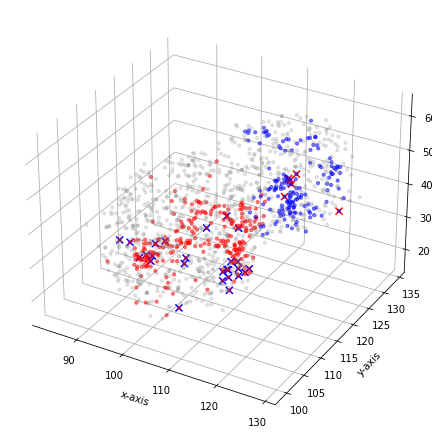

In [30]:
interactive_plot(cell_data, data, chr_, np.array(cell_chr_df.cluster) )

In [142]:
def dist(x1, x2):
    return np.linalg.norm(x1-x2)

def get_loss(n, data, labels, constraints,means = None):
    X = data[0:n]
    X_labels = labels[0:n]
    if means is None:
        means = np.array([X[X_labels == i].mean(axis=0) for i in [0,1]])
#     assert constraints.shape[0] == n
    loss = 0
    for i in range(n):

        loss +=  0.5 * dist(data[i], means[int(labels[i])])**2
        
        do_not_links = np.where(constraints[i] < 0)[0] 
#         print("do not links: ",do_not_links)
        do_links = np.where(constraints[i] > 0)[0]
        for j in do_not_links:
            if (labels[j] != -1) and (labels[j] == labels[i]): 
                loss += abs(constraints[i,j]) ####MAKE SURE i<j#######
                
                #cluster separation
            i_j_vec = data[j] - data[i]
            i_mu_k_vec = means[int(labels[i])] - data[i]
            i_j_pojected = np.dot(i_j_vec, i_mu_k_vec) / (np.linalg.norm(i_mu_k_vec)**2) * i_mu_k_vec
            orthogonal_component = np.linalg.norm(i_j_vec - i_j_pojected)
#             print(orthogonal_component)

            if np.linalg.norm(i_mu_k_vec) > np.linalg.norm(i_j_vec) and\
            pckmeans.correlation(i_j_vec, i_mu_k_vec) > 0 and\
            orthogonal_component < pckmeans.radius_threshold: 
#                 print("hello")
                loss += pckmeans.separation_penalty / (dist(data[i], means[int(labels[i])])+1e-6) #normal
        for j in do_links:
            if (labels[j] != -1) and (labels[j] != labels[i]): 
                loss += abs(constraints[i,j])
#                 print(i,j, abs(constraints[i,j]))
    return loss
    

In [163]:
print("pckmeans loss: ", get_loss(chr_n, data,  pckmeans.labels, pckmeans.constraints) )
print("pckmeans loss after variance correction: ", get_loss(chr_n, data,  pckmeans.likelihood_correction(), pckmeans.constraints) )
# print("gmm loss: ", get_loss(chr_n, data,  gmm_labels, pckmeans.constraints) )

igs_means = np.array(cell_chr_df.groupby('cluster').mean()[['x_um_abs', 'y_um_abs', 'z_um_abs']])
print("igs loss: ", get_loss(chr_n, data, np.append(np.array(cell_chr_df.cluster)-1, 2*np.ones(not_chr_n)), pckmeans.constraints, igs_means) )


pckmeans loss:  4461.156458673347
pckmeans loss after variance correction:  4461.156458673347
igs loss:  7941.238896281867


In [97]:
np.array(cell_chr_df.cluster)-1

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0])

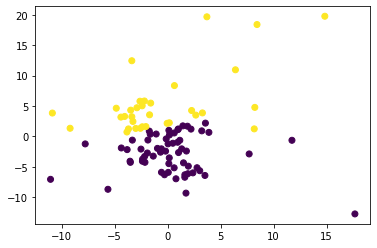

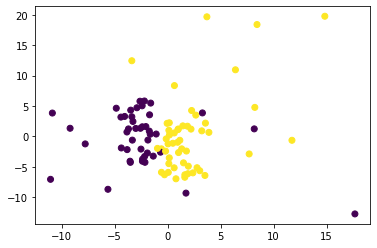

In [18]:
dist_mat=sp.spatial.distance.cdist(X,X)
mds = MDS(dissimilarity='precomputed', random_state=0, n_components = 2)
chr_2d = mds.fit_transform(dist_mat)

%matplotlib inline
plt.figure()
plt.scatter(x = chr_2d[:,0], y = chr_2d[:,1], c = chr_labels) 
plt.figure()
plt.scatter(x = chr_2d[:,0], y = chr_2d[:,1], c = cell_chr_df.cluster)
# chr_2d.shape

In [45]:
id_ = 49
label = int(labels[id_])
ind = (labels[:chr_n]==label) 
print("before removing: variance of distance b/w purple points and cluster means: ", np.round(np.var(pckmeans.dist_mat[ind,label], axis = 0),2)) 
ind = (labels[:chr_n]==label) &(np.arange(0,chr_n) != id_)#(data[:,0] < 106)
print("after removing: variance of distance b/w purple points and cluster means: ", np.round(np.var(pckmeans.dist_mat[ind,label], axis = 0),2)) 

ind = (labels[:chr_n]==1-label) 
print("before adding: variance of distance b/w green points and cluster means: ", np.round(np.var(pckmeans.dist_mat[ind,1-label], axis = 0),2)) 
ind = (labels[:chr_n]==1-label) | (np.arange(0,chr_n) == id_)
print("after adding: variance of distance b/w green points and cluster means: ", np.round(np.var(pckmeans.dist_mat[ind,1-label], axis = 0),2)) 


before removing: variance of distance b/w purple points and cluster means:  12.54
after removing: variance of distance b/w purple points and cluster means:  8.86
before adding: variance of distance b/w green points and cluster means:  18.52
after adding: variance of distance b/w green points and cluster means:  19.54


  ---------  
num_components =  2
cluster separation penalty =  10
cluster separation radius threshold =  1
  ---------  
given negative constraints: initializing means with seed 0
[[104.2255 120.4563  40.9575]
 [ 97.0753 131.1814  57.3575]]


  2%|█▉                                                                         | 1/40 [00:01<01:01,  1.58s/it]


given negative constraints: initializing means with seed 100
[[ 97.1978 120.3413  41.3061]
 [ 90.0477 131.0665  57.7061]]


  5%|███▊                                                                       | 2/40 [00:02<00:45,  1.20s/it]


given negative constraints: initializing means with seed 1000
[[ 99.0884 120.2978  38.949 ]
 [ 91.9383 131.023   55.349 ]]


  2%|█▉                                                                         | 1/40 [00:01<00:59,  1.54s/it]


losses of the different runs:  [1631.31 1631.31 1631.31]


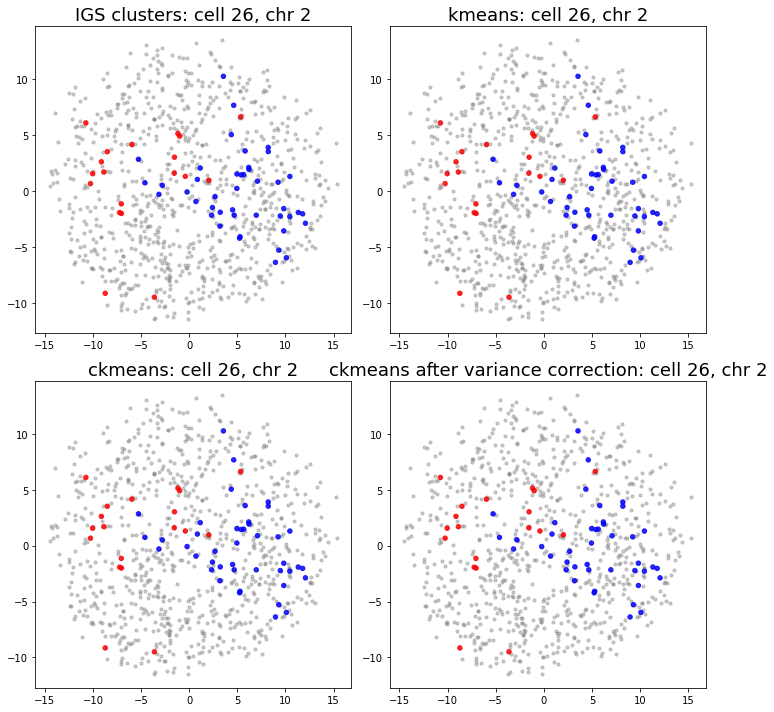

  ---------  
num_components =  2
cluster separation penalty =  10
cluster separation radius threshold =  1
  ---------  
given negative constraints: initializing means with seed 0
[[105.3088 132.1565  50.9575]
 [ 93.2836 128.2564  32.5575]]


  2%|█▉                                                                         | 1/40 [00:01<00:50,  1.30s/it]


given negative constraints: initializing means with seed 100
[[ 98.2812 132.0415  51.3061]
 [ 86.256  128.1414  32.9061]]


  5%|███▊                                                                       | 2/40 [00:01<00:37,  1.01it/s]


given negative constraints: initializing means with seed 1000
[[100.1718 131.998   48.949 ]
 [ 88.1466 128.0979  30.549 ]]


  5%|███▊                                                                       | 2/40 [00:01<00:37,  1.02it/s]


losses of the different runs:  [1412.67 1432.53 1432.53]


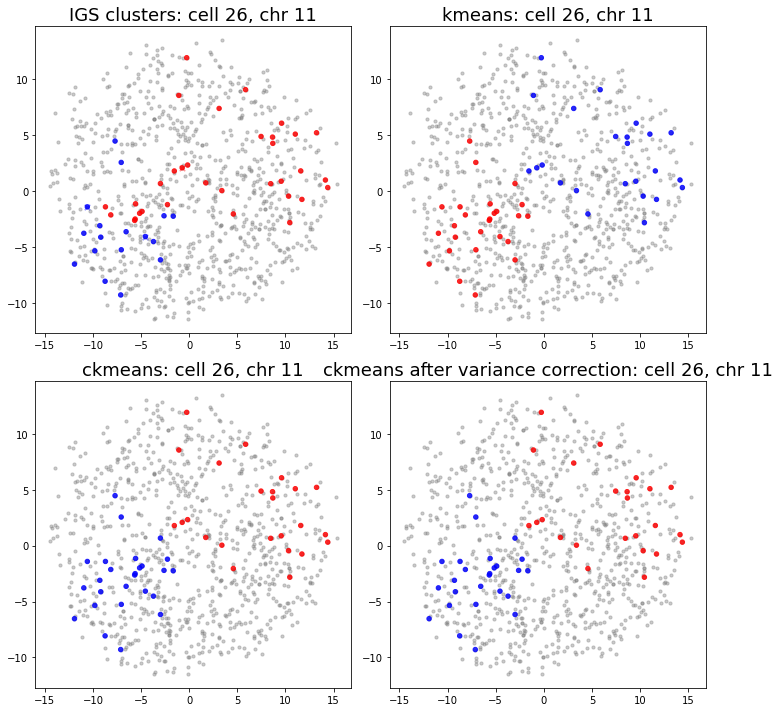

  ---------  
num_components =  2
cluster separation penalty =  10
cluster separation radius threshold =  1
  ---------  
given negative constraints: initializing means with seed 0
[[103.9004 116.7729  49.7575]
 [110.7255 126.0897  49.3575]]


  2%|█▉                                                                         | 1/40 [00:00<00:28,  1.35it/s]


given negative constraints: initializing means with seed 100
[[ 96.8728 116.6579  50.1061]
 [103.6979 125.9747  49.7061]]


  8%|█████▋                                                                     | 3/40 [00:01<00:18,  2.02it/s]


given negative constraints: initializing means with seed 1000
[[ 98.7634 116.6144  47.749 ]
 [105.5885 125.9312  47.349 ]]


  2%|█▉                                                                         | 1/40 [00:00<00:26,  1.45it/s]


losses of the different runs:  [621.45 628.84 628.84]
1e-06 0.0
25 : switched label 



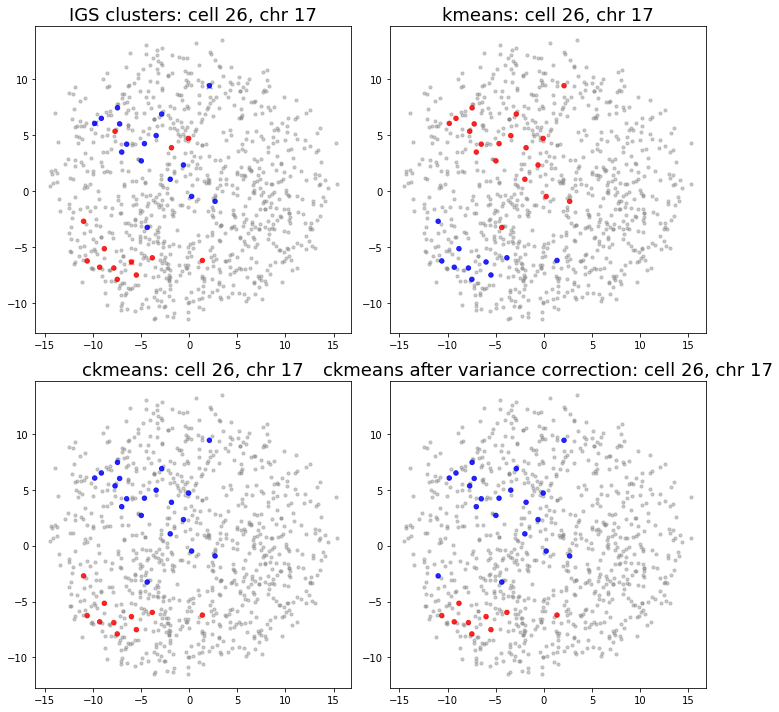

  ---------  
num_components =  2
cluster separation penalty =  10
cluster separation radius threshold =  1
  ---------  
given negative constraints: initializing means with seed 0
[[113.5423 137.3565  41.7575]
 [130.2258 135.8398  52.9575]]


  8%|█████▋                                                                     | 3/40 [00:33<06:54, 11.20s/it]


given negative constraints: initializing means with seed 100
[[106.5146 137.2416  42.1061]
 [123.1982 135.7249  53.3061]]


 15%|███████████▎                                                               | 6/40 [00:58<05:30,  9.73s/it]


given negative constraints: initializing means with seed 1000
[[108.4052 137.1981  39.749 ]
 [125.0888 135.6814  50.949 ]]


 15%|███████████▎                                                               | 6/40 [00:57<05:26,  9.59s/it]


losses of the different runs:  [5836.46 5836.46 5836.46]
0.0 0.0
0 : switched label 



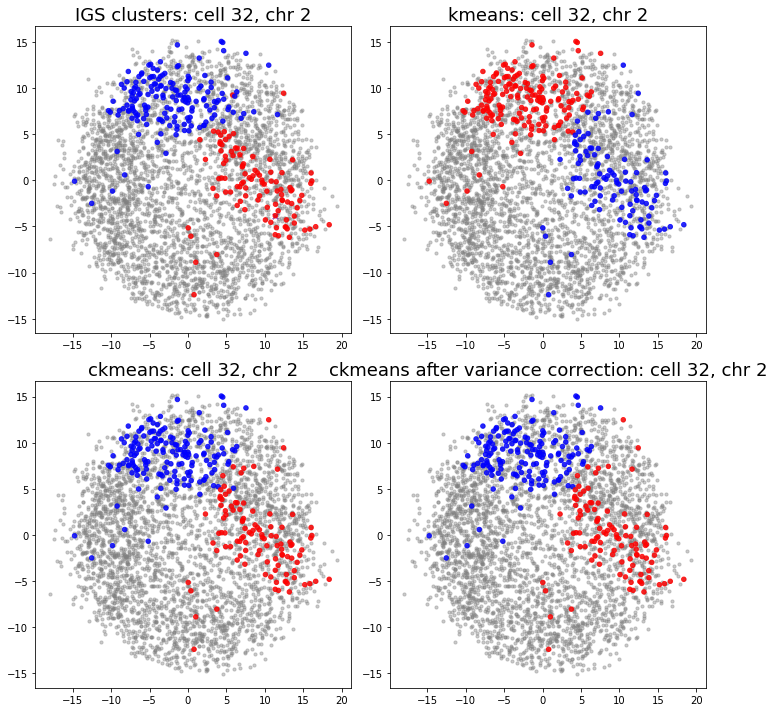

  ---------  
num_components =  2
cluster separation penalty =  10
cluster separation radius threshold =  1
  ---------  
given negative constraints: initializing means with seed 0
[[116.684  139.3066  47.7575]
 [129.9008 132.8065  41.3575]]


  2%|█▉                                                                         | 1/40 [00:05<03:35,  5.53s/it]


given negative constraints: initializing means with seed 100
[[109.6563 139.1916  48.1061]
 [122.8732 132.6915  41.7061]]


  8%|█████▋                                                                     | 3/40 [00:10<02:12,  3.57s/it]


given negative constraints: initializing means with seed 1000
[[111.547  139.1481  45.749 ]
 [124.7638 132.648   39.349 ]]


  5%|███▊                                                                       | 2/40 [00:07<02:30,  3.97s/it]


losses of the different runs:  [4227.44 4227.44 4227.44]
4e-06 0.0
71 : switched label 



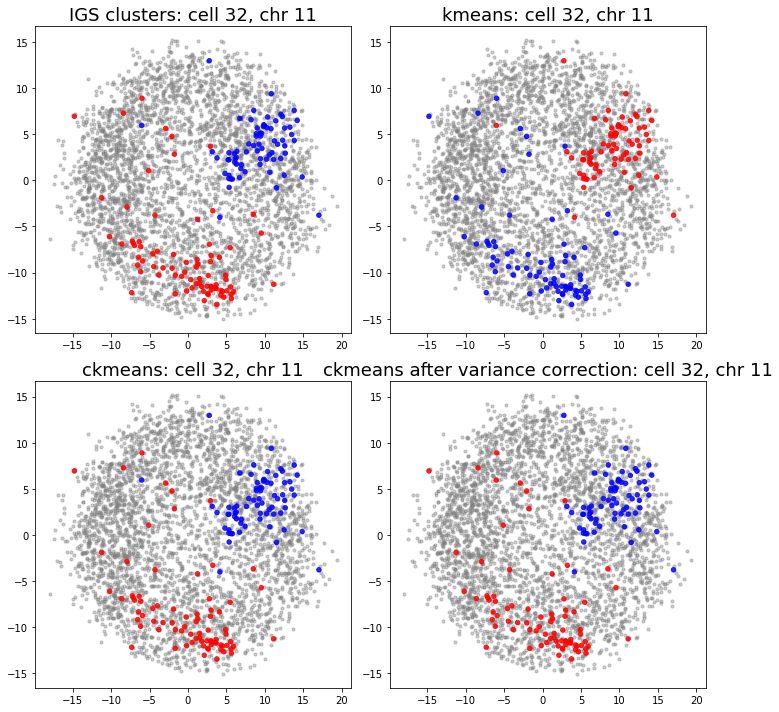

  ---------  
num_components =  2
cluster separation penalty =  10
cluster separation radius threshold =  1
  ---------  
given negative constraints: initializing means with seed 0
[[136.6176 132.6981  32.1575]
 [114.7339 137.5732  32.1575]]


  8%|█████▋                                                                     | 3/40 [00:11<02:21,  3.83s/it]


given negative constraints: initializing means with seed 100
[[129.59   132.5832  32.5061]
 [107.7063 137.4582  32.5061]]


  8%|█████▋                                                                     | 3/40 [00:11<02:20,  3.80s/it]


given negative constraints: initializing means with seed 1000
[[131.4806 132.5397  30.149 ]
 [109.5969 137.4148  30.149 ]]


  5%|███▊                                                                       | 2/40 [00:08<02:43,  4.29s/it]


losses of the different runs:  [3512.98 3512.98 3512.98]
0.0 0.0
102 : switched label 



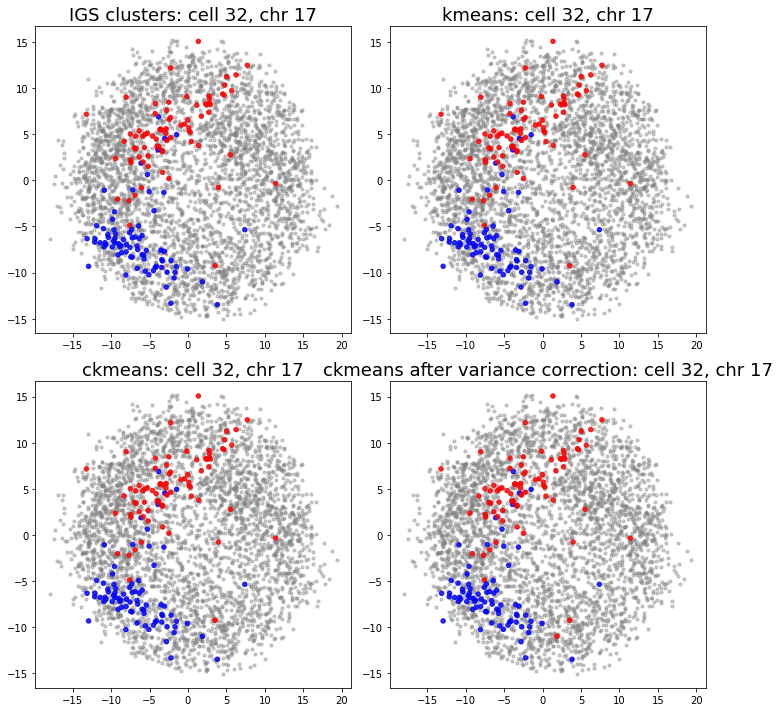

  ---------  
num_components =  2
cluster separation penalty =  10
cluster separation radius threshold =  1
  ---------  
No negative constraints: initializing means with seed 0
[[ 97.4473 142.948   55.4   ]
 [ 97.8806 141.8646  41.8   ]]


  8%|█████▋                                                                     | 3/40 [00:02<00:26,  1.41it/s]


No negative constraints: initializing means with seed 100
[[101.564  142.5146  37.8   ]
 [107.5224 139.2646  47.4   ]]


  2%|█▉                                                                         | 1/40 [00:01<00:41,  1.05s/it]


No negative constraints: initializing means with seed 1000
[[103.0807 142.298   49.    ]
 [100.589  141.4313  48.6   ]]


 10%|███████▌                                                                   | 4/40 [00:02<00:23,  1.52it/s]


losses of the different runs:  [915.93 919.95 919.7 ]
0.0 0.0
14 : switched label 



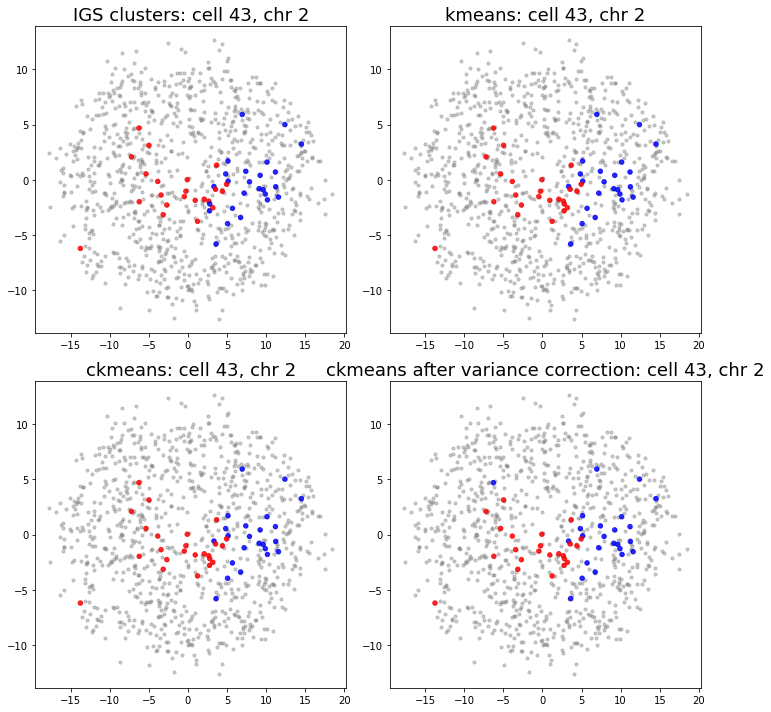

  ---------  
num_components =  2
cluster separation penalty =  10
cluster separation radius threshold =  1
  ---------  
No negative constraints: initializing means with seed 0
[[114.2392 139.3729  45.4   ]
 [108.8225 134.3895  47.    ]]


  5%|███▊                                                                       | 2/40 [00:01<00:33,  1.15it/s]


No negative constraints: initializing means with seed 100
[[105.5724 148.3647  27.4   ]
 [106.0058 138.6146  54.2   ]]


  2%|█▉                                                                         | 1/40 [00:01<00:47,  1.22s/it]


No negative constraints: initializing means with seed 1000
[[106.8724 137.8562  51.8   ]
 [111.0975 134.7145  43.    ]]


  8%|█████▋                                                                     | 3/40 [00:02<00:29,  1.26it/s]


losses of the different runs:  [633.79 633.79 633.79]
0.0 0.0
37 : switched label 



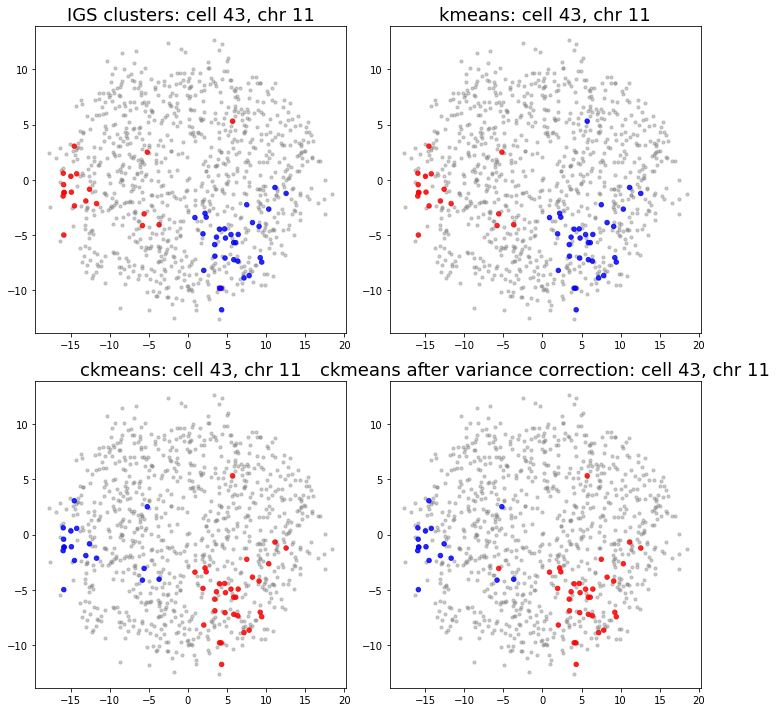

  ---------  
num_components =  2
cluster separation penalty =  10
cluster separation radius threshold =  1
  ---------  
No negative constraints: initializing means with seed 0
[[ 99.5057 141.4313  39.8   ]
 [110.0142 137.0979  39.4   ]]


  2%|█▉                                                                         | 1/40 [00:00<00:27,  1.40it/s]


No negative constraints: initializing means with seed 100
[[101.1307 139.8063  43.8   ]
 [100.8057 139.1563  42.6   ]]


 20%|███████████████                                                            | 8/40 [00:03<00:14,  2.28it/s]


No negative constraints: initializing means with seed 1000
[[100.589  139.9146  41.4   ]
 [100.1557 138.3979  45.    ]]


 18%|█████████████▏                                                             | 7/40 [00:03<00:14,  2.24it/s]


losses of the different runs:  [314.98 314.98 314.98]


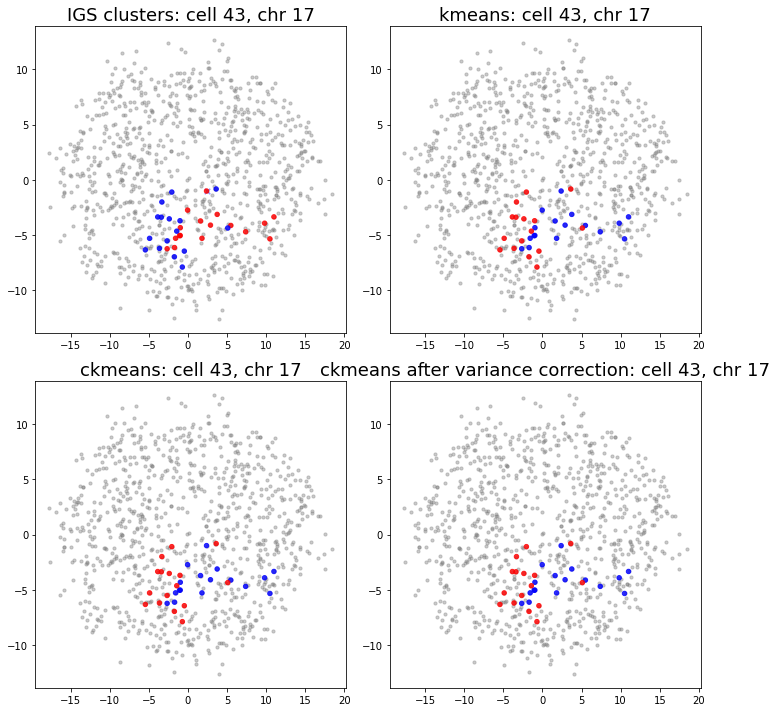

  ---------  
num_components =  2
cluster separation penalty =  10
cluster separation radius threshold =  1
  ---------  
given negative constraints: initializing means with seed 0
[[166.6264  87.6308  34.1575]
 [167.0597  82.7557  38.9575]]


 18%|█████████████▏                                                             | 7/40 [00:09<00:45,  1.39s/it]


given negative constraints: initializing means with seed 100
[[159.5988  87.5158  34.5061]
 [160.0321  82.6408  39.3061]]


 18%|█████████████▏                                                             | 7/40 [00:09<00:44,  1.35s/it]


given negative constraints: initializing means with seed 1000
[[161.4894  87.4723  32.149 ]
 [161.9227  82.5973  36.949 ]]


  8%|█████▋                                                                     | 3/40 [00:04<00:57,  1.56s/it]


losses of the different runs:  [860.02 860.02 867.45]
0.000642 3e-06
53 : switched label 



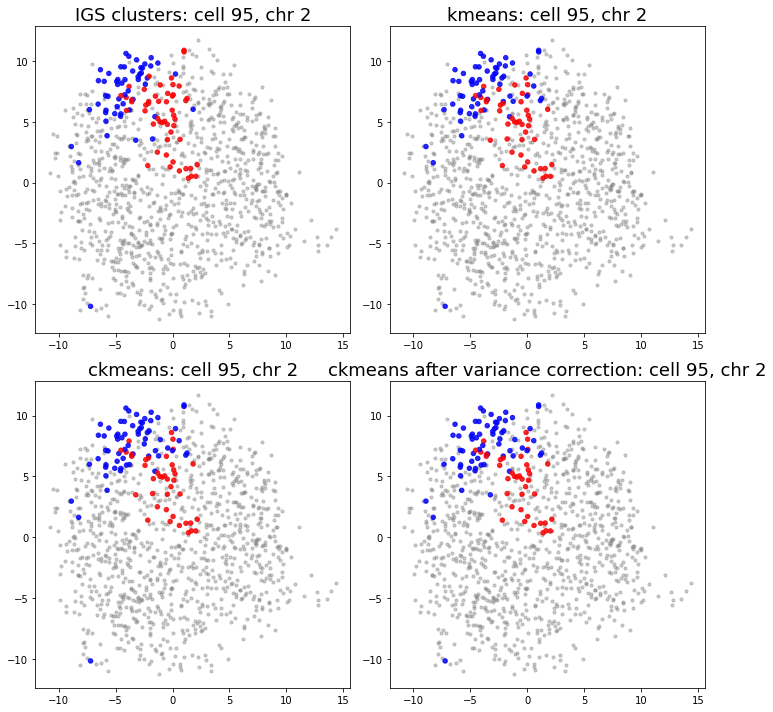

  ---------  
num_components =  2
cluster separation penalty =  10
cluster separation radius threshold =  1
  ---------  
given negative constraints: initializing means with seed 0
[[179.9516  77.2306  38.1575]
 [171.2848  81.4557  29.7575]]


 25%|██████████████████▌                                                       | 10/40 [00:07<00:22,  1.34it/s]


given negative constraints: initializing means with seed 100
[[172.924   77.1157  38.5061]
 [164.2572  81.3407  30.1061]]


 22%|████████████████▉                                                          | 9/40 [00:06<00:23,  1.32it/s]


given negative constraints: initializing means with seed 1000
[[174.8146  77.0722  36.149 ]
 [166.1478  81.2972  27.749 ]]


 22%|████████████████▉                                                          | 9/40 [00:06<00:23,  1.33it/s]


losses of the different runs:  [751.27 751.27 751.27]


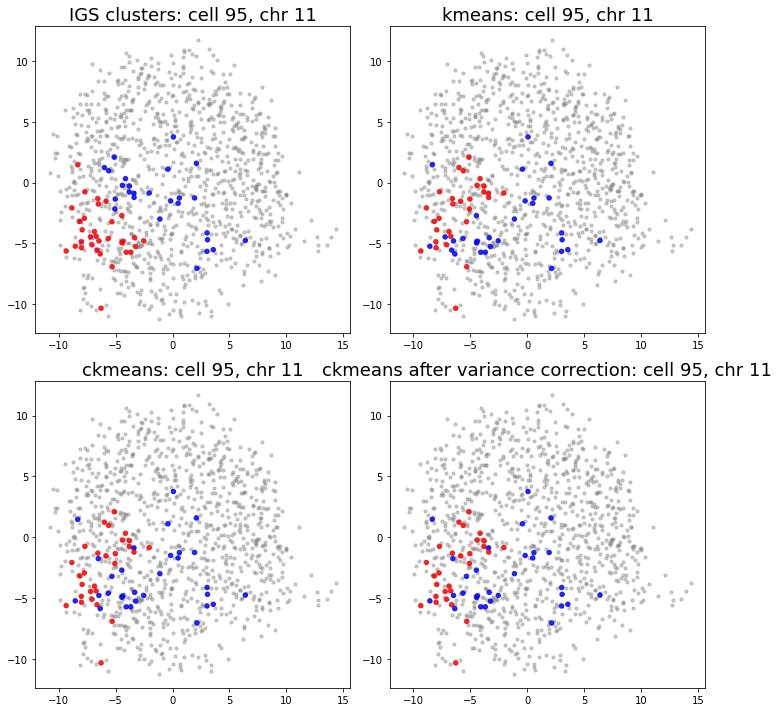

  ---------  
num_components =  2
cluster separation penalty =  10
cluster separation radius threshold =  1
  ---------  
No negative constraints: initializing means with seed 0
[[167.9734  82.7137  25.    ]
 [174.9068  80.6554  32.6   ]]


  8%|█████▋                                                                     | 3/40 [00:02<00:25,  1.45it/s]


No negative constraints: initializing means with seed 100
[[167.6484  87.0471  24.2   ]
 [168.2984  78.922   39.8   ]]


  5%|███▊                                                                       | 2/40 [00:01<00:29,  1.27it/s]


No negative constraints: initializing means with seed 1000
[[173.2818  79.6804  34.2   ]
 [170.4651  80.9804  27.    ]]


  8%|█████▋                                                                     | 3/40 [00:02<00:25,  1.44it/s]


losses of the different runs:  [494.82 494.82 494.82]
5e-06 0.0
15 : switched label 



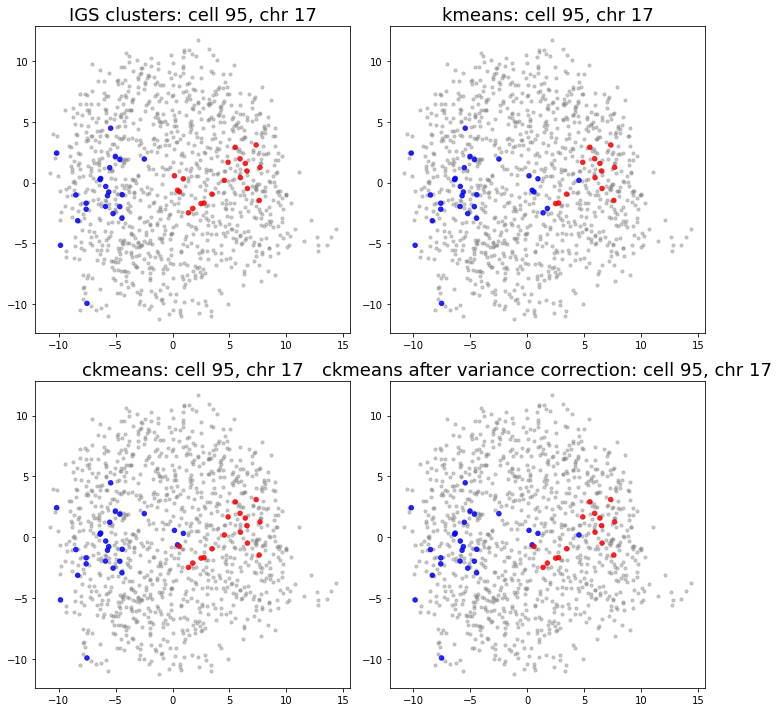

In [4]:
embryo = pd.read_csv("data/embryo_data.csv")
for cell_index in [26, 32, 43, 95]:
    for chr_ in [2, 11, 17]:
        
        cell_df = embryo.loc[embryo.cell_index==cell_index]
        chr_index = np.where(cell_df.chr==chr_)
        not_chr_index = np.where(cell_df.chr!=chr_)
        not_chr_index_sampled = np.random.choice(not_chr_index[0], size = max(2*len(chr_index[0]), 200))
        cell_chr_df = cell_df.iloc[chr_index]
        cell_not_chr_df = cell_df.iloc[not_chr_index_sampled]

        #this is the data that is getting clustered
        X=np.array(cell_chr_df[['x_um_abs','y_um_abs','z_um_abs']]) #this is the data that will be clustered into 2 clusters
        not_X =  np.array(cell_not_chr_df[['x_um_abs','y_um_abs','z_um_abs']])
        data = np.vstack((X,not_X))
        chr_n = X.shape[0]
        not_chr_n = not_X.shape[0]
        n = data.shape[0]

        #positive constraints among the "cell_not_chr" reads, and negative constraint b/w different chromosomes
        constraints = np.zeros((n,n))
        constraints[-not_chr_n:, -not_chr_n:] = 10
        constraints[:chr_n, -not_chr_n:] = -10
        constraints[:chr_n, :chr_n] = get_constraint_matrix(cell_chr_df)
        
        
        #run the clustering algorithm with the constraints
        pckmeans = PCKMeans(2, constraints, data, chr_n = chr_n, separation_penalty=10, radius_threshold = 1)
        labels = pckmeans.fit_and_get_total_loss([],visualize = False)

   
        #visualize and compare
        PCA_2d_visualize_clusters(cell_index, chr_, chr_index, labels[:chr_n], pckmeans.likelihood_correction()[:chr_n])
        

In [ ]:
%matplotlib inline
#for visualizing a large number of constraints in smaller chunks
n = X.shape[0]

for m in range(0,n,15):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(cell_.x_um_abs, cell_.y_um_abs, cell_.z_um_abs, alpha = 0.1, c = 'gray')
    ax.scatter(X[:,0], X[:,1], X[:,2])
    for i in range(m,m+15):
        for j in range(i,n):
            if constraints[i,j] > 0:
                ax.plot(X[(i,j),0], X[(i,j),1], X[(i,j),2], 'g-')
                ax.text(X[i,0], X[i,1] + 0.1, X[i,2] + 0.1, i)
                ax.text(X[j,0], X[j,1] + 0.1, X[j,2] + 0.1, j)
            if constraints[i,j] < 0:
                ax.plot(X[(i,j),0], X[(i,j),1], X[(i,j),2], 'r--')
                ax.text(X[i,0], X[i,1] + 0.1, X[i,2] + 0.1, i)
                ax.text(X[j,0], X[j,1] + 0.1, X[j,2] + 0.1, j)
    plt.show()

# plt.show()

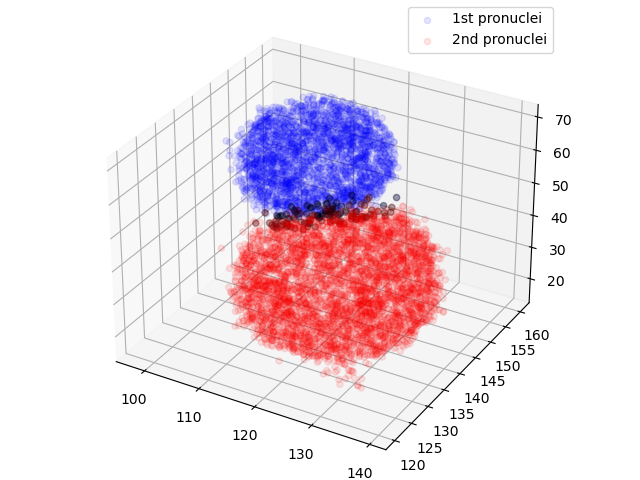

In [13]:

%matplotlib widget
# creating figure
fig = plt.figure()
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)
cell_ = np.array(cell_df[['x_um_abs','y_um_abs','z_um_abs']])
labels = gmm_for_zygote(1).predict(cell_)
probs = np.max(gmm_for_zygote(1).predict_proba(cell_),axis = 1)
cl0 = np.where(labels==0)
cl1 = np.where(labels==1)
ax.scatter(cell_[cl0,0], cell_[cl0,1], cell_[cl0,2], c = 'blue', alpha = 0.1, label = "1st pronuclei")
ax.scatter(cell_[cl1,0], cell_[cl1,1], cell_[cl1,2], c = 'red', alpha = 0.1, label = "2nd pronuclei")
ax.scatter(cell_[probs<0.65,0], cell_[probs<0.65,1], cell_[probs<0.65,2], c = 'black', alpha = 0.3)
plt.legend()

In [16]:
%matplotlib inline
def PCA_2d_compare_clusters(): 
    data = pd.read_csv("data/pckmeans_embryo_data.csv")
    igs_data = pd.read_csv("data/embryo_data.csv", usecols = ['cell_index', 'chr', 'hap1_reads', 'hap2_reads', 'cluster', 'cluster_hap_imputed', 'inlier'])
    chrs = 21
    cells= np.arange(1,114) 
    for cell_id in cells: 
        print(cell_id)
        fig = plt.figure(figsize = (8,60))
        for ch in range(1,chrs+1):
            
            cell_ = data.loc[data.cell_index == cell_id]
            chr_index = np.where(cell_.chr==ch)
            cell_chr = cell_.loc[cell_.chr == ch]
            mat_idx = np.where((cell_.chr == ch) & (cell_.hap1_reads > 0))
            pat_idx = np.where((cell_.chr == ch) & (cell_.hap2_reads > 0))
            outlier_idx = np.where((cell_chr.outlier !=0 ))
            igs_oulier_idx = np.where(igs_data.loc[(igs_data.cell_index == cell_id) & (igs_data.chr == ch), 'inlier'] != 1)
            # for visualization purposes, let's project the data into 2d
            pca = PCA(n_components=2, svd_solver='full')

            
            igs_clusters = np.array(igs_data.loc[(igs_data.cell_index == cell_id) & (igs_data.chr == ch), 'cluster'])
            pckmeans_clusters = np.array(cell_.iloc[chr_index]['pckmeans_cluster'])
    
     
            cell_ = cell_[['x_um_abs','y_um_abs','z_um_abs']]
            reduced_cell = pca.fit_transform(np.array(cell_))
            reduced_cell_chr =reduced_cell[chr_index]

            ax = fig.add_subplot(chrs , 2,  2 *  ch - 1 )
            ax.scatter(reduced_cell[:,0], reduced_cell[:,1],c = 'gray', alpha = 0.1, s = 10)
            ax.scatter(reduced_cell[mat_idx,0], reduced_cell[mat_idx,1],c = 'red', alpha = 0.8, s = 30, marker = 'x')
            ax.scatter(reduced_cell[pat_idx,0], reduced_cell[pat_idx,1],c = 'blue', alpha = 0.8, s = 30, marker = 'x')
            ax.scatter(reduced_cell_chr[:,0], reduced_cell_chr[:,1],c = igs_clusters, alpha = 0.4, cmap = 'bwr', s = 15)
            ax.scatter(reduced_cell_chr[igs_oulier_idx,0], reduced_cell_chr[igs_oulier_idx,1],c = igs_clusters[igs_oulier_idx], alpha = 1, marker = "3", cmap = 'bwr', s = 40)
            ax.set_title("IGS clusters: cell {}, chr {}".format(cell_id, ch), fontsize = 18)

            ax = fig.add_subplot(chrs , 2,  2*  ch  )
            ax.scatter(reduced_cell[:,0], reduced_cell[:,1],c = 'gray', alpha = 0.1, s = 10)
            ax.scatter(reduced_cell[mat_idx,0], reduced_cell[mat_idx,1],c = 'red', alpha = 0.8, s = 40, marker = 'x')
            ax.scatter(reduced_cell[pat_idx,0], reduced_cell[pat_idx,1],c = 'blue', alpha = 0.8, s = 40, marker = 'x')
            ax.scatter(reduced_cell_chr[:,0], reduced_cell_chr[:,1],c = pckmeans_clusters, alpha = 0.4, cmap = 'bwr', s = 15)
            ax.scatter(reduced_cell_chr[outlier_idx,0], reduced_cell_chr[outlier_idx,1],c = pckmeans_clusters[outlier_idx], alpha = 1, marker = "3", cmap = 'bwr', s = 40)
            ax.set_title("pckmeans: cell {}, chr {}".format(cell_id, ch), fontsize = 18)
 
        plt.savefig("figures/pckmeans_clusters/cell_{}".format(cell_id),bbox_inches='tight')
        plt.close()
PCA_2d_compare_clusters()


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113


In [29]:
x = np.array([1,1,1, 0,0])
_, counts_elements = np.unique(x, return_counts=True)
counts_elements

array([0.4, 0.6])

In [4]:
%matplotlib inline
def PCA_pckmeans_clusters_all(): 
    fig = plt.figure(figsize = (60,240))
    data = pd.read_csv("data/pckmeans_embryo_data_1-113.csv")
    chrs = 19
    cells= np.arange(1,10) #113 
    for cell_id in cells: #range(1,cells+1):
        print(cell_id)
        for ch in range(1,chrs+1):
            
            cell_ = data.loc[data.cell_index == cell_id]
            chr_index = np.where(cell_.chr==ch)
            cell_chr = cell_.loc[cell_.chr == ch]
            mat_idx = np.where((cell_.chr == ch) & (cell_.hap1_reads > 0))
            pat_idx = np.where((cell_.chr == ch) & (cell_.hap2_reads > 0))
            outlier_idx = np.where((cell_chr.outlier == 1))
   
            # for visualization purposes, let's project the data into 2d
            pca = PCA(n_components=2, svd_solver='full')

            pckmeans_clusters = np.array(cell_.iloc[chr_index]['pckmeans_cluster_hap'])
    
     
            cell_ = cell_[['x_um_abs','y_um_abs','z_um_abs']]
            reduced_cell = pca.fit_transform(np.array(cell_))
            reduced_cell_chr =reduced_cell[chr_index]

           
            ax = fig.add_subplot(len(cells), chrs, ch + (cell_id-1)*(chrs))
            ax.scatter(reduced_cell[:,0], reduced_cell[:,1],c = 'gray', alpha = 0.1, s = 10)
            ax.scatter(reduced_cell[mat_idx,0], reduced_cell[mat_idx,1],c = 'red', alpha = 0.8, s = 30, marker = 'x')
            ax.scatter(reduced_cell[pat_idx,0], reduced_cell[pat_idx,1],c = 'blue', alpha = 0.8, s = 30, marker = 'x')
            ax.scatter(reduced_cell_chr[:,0], reduced_cell_chr[:,1],c = pckmeans_clusters, alpha = 0.4, cmap = 'bwr', s = 15)
            ax.scatter(reduced_cell_chr[outlier_idx,0], reduced_cell_chr[outlier_idx,1], c = pckmeans_clusters[outlier_idx], alpha = 1, marker = "3", cmap = 'bwr', s = 40)
            
            ax.set_title("cell {}, chr {}".format(cell_id, ch), fontsize = 18)
 
        plt.savefig("figures/pckmeans_clusters/all_pckmeans".format(cell_id),bbox_inches='tight')
    plt.close()
PCA_pckmeans_clusters_all()


1
2
3
4
5
6
7
8
9


In [46]:
len(np.arange(1,10))

9

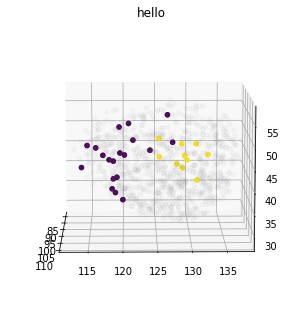

In [8]:
def make_movie(cell_index, chr_, method):
    if method=='pckmeans':
        x = pd.read_csv("data/pckmeans_embryo_data.csv")
        cell = x.loc[x.cell_index == cell_index]
        x = cell.loc[cell.chr == chr_]
        labels = x.pckmeans_cluster
    else:
        x = pd.read_csv("data/embryo_data.csv")
        cell = x.loc[x.cell_index == cell_index]
        x = cell.loc[cell.chr == chr_]
        labels = x.cluster
        
    x = np.array(x[['x_um_abs','y_um_abs','z_um_abs']])
    cell = np.array(cell[['x_um_abs','y_um_abs','z_um_abs']])
    
    
    # Create a figure and a 3D Axes
    fig = plt.figure()
    ax = Axes3D(fig,auto_add_to_figure=False)
    fig.add_axes(ax)
    
    def init():
        ax.scatter(cell[:,0], cell[:,1], cell[:,2],  c='gray', alpha=0.02)
        ax.scatter(x[:,0], x[:,1], x[:,2], c=labels, alpha=0.8)
        ax.set_title("hello")
        return fig,

    def animate(i):
        ax.view_init(elev=10., azim=i)
        return fig,
    
    # Animate
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=360, interval=20, blit=True)
    # Save
    # anim.save('testing.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
    anim.save('testing_cell{}_chr{}_{}.gif'.format(cell_index, chr_, method), writer='imagemagick', fps=20)

    
# np.all(x.pckmeans_cluster == chr_labels)
# x.pckmeans_cluster == chr_labels
make_movie(26,17, 'pckmeans')

In [15]:
x = pd.read_csv('data/pckmeans_embryo_data_1-113.csv')
# y = pd.read_csv('data/pckmeans_embryo_data_31-55.csv')
# z = pd.read_csv('data/pckmeans_embryo_data_56-113.csv')

# data.to_csv('data/pckmeans_embryo_data.csv', index = False)

# x.loc[(x.cell_index==25) & (x.chr==15), 'pckmeans_cluster'] = x.loc[(x.cell_index==25) & (x.chr==15), 'pckmeans_before_correction']
# x.loc[(x.cell_index==25) & (x.chr==8), 'pckmeans_cluster'] = x.loc[(x.cell_index==25) & (x.chr==8), 'pckmeans_before_correction']

# x.loc[(x.cell_index==25) & (x.chr==15)]
# x.loc[(x.cell_index==68) & (x.chr==15), 'pckmeans_cluster'] = chr_labels
# x.loc[(x.cell_index==68) & (x.chr==15), 'pckmeans_before_correction'] = pckmeans.likelihood_correction()[:chr_n]
# data = pd.concat([x,y,z], axis = 0)
x.to_csv('data/pckmeans_embryo_data.csv', index = False)


## Validating The Clustering 

In [5]:
from run_dist_mat import *
reads_to_inlcude = "inliers" #"all"
# clustering_method = "pckmeans" # "igs"


data_pckmeans = read_data('pckmeans', reads_to_inlcude) 
data_igs = read_data("igs", reads_to_inlcude) 

In [80]:
scores = []
for cell_idx in data_pckmeans.cell_index.unique()[30:]:
    for chr_num in range(1, 20):

        cell_pck = data_pckmeans.loc[(data_pckmeans.cell_index == cell_idx)&(data_pckmeans.chr==chr_num), ['hap1_reads', 'hap2_reads', 'pckmeans_cluster', 'pckmeans_cluster_hap']]
        cell_igs = data_igs.loc[(data_igs.cell_index == cell_idx)&(data_igs.chr==chr_num), ['hap1_reads', 'hap2_reads', 'cluster', 'cluster_hap_imputed']]

        pckmeans_cluster_snps = np.array(cell_pck.groupby('pckmeans_cluster').sum()[['hap1_reads', 'hap2_reads']])
        igs_cluster_snps = np.array(cell_igs.groupby('cluster').sum()[['hap1_reads', 'hap2_reads']])

        if (np.sum(pckmeans_cluster_snps) != 0) & (np.sum(igs_cluster_snps) != 0):
            igs_mat = np.array(cell_igs.groupby('cluster').sum()[['hap1_reads', 'hap2_reads']])
            pckmeans_mat = np.array(cell_pck.groupby('pckmeans_cluster').sum()[['hap1_reads', 'hap2_reads']])
          
            if (igs_mat.shape ==(2,2)) & (pckmeans_mat.shape ==(2,2)):
                if (not np.all(pckmeans_mat == igs_mat)) & (not np.all(pckmeans_mat == igs_mat[[1,0]])):
                    print('------------')
                    print(cell_idx, chr_num)

                    print(igs_mat, '\n', pckmeans_mat)
                    pckmeans_score = find_sum_of_off_diagonal(pckmeans_mat)
                    igs_score = find_sum_of_off_diagonal(igs_mat)
                    scores.append(pckmeans_score - igs_score)
                    print(pckmeans_score, ' - ', igs_score, ' = ', scores[-1])
            

------------
31 1
[[ 0 25]
 [ 7  2]] 
 [[ 7  0]
 [ 0 23]]
0  -  2  =  -2
------------
31 2
[[7 0]
 [1 0]] 
 [[8 0]
 [0 0]]
0  -  1  =  -1
------------
31 4
[[0 0]
 [2 3]] 
 [[2 0]
 [0 3]]
0  -  2  =  -2
------------
31 5
[[ 0  2]
 [12  1]] 
 [[ 0  1]
 [12  1]]
1  -  1  =  0
------------
31 8
[[6 0]
 [0 2]] 
 [[0 2]
 [5 0]]
0  -  0  =  0
------------
32 7
[[ 4 16]
 [ 3  0]] 
 [[ 4  1]
 [ 4 16]]
5  -  4  =  1
------------
32 11
[[1 1]
 [3 0]] 
 [[4 0]
 [1 1]]
1  -  1  =  0
------------
33 3
[[ 0  4]
 [23  1]] 
 [[ 0 12]
 [23  1]]
1  -  1  =  0
------------
33 12
[[ 4  1]
 [ 0 11]] 
 [[ 0  1]
 [ 0 11]]
1  -  1  =  0
------------
35 5
[[1 0]
 [1 0]] 
 [[0 0]
 [2 0]]
0  -  1  =  -1
------------
36 1
[[ 1 26]
 [ 0  0]] 
 [[ 0  0]
 [ 0 26]]
0  -  1  =  -1
------------
36 5
[[0 3]
 [3 0]] 
 [[1 0]
 [0 3]]
0  -  0  =  0
------------
36 17
[[6 1]
 [0 0]] 
 [[6 0]
 [0 0]]
0  -  1  =  -1
------------
38 4
[[0 0]
 [0 4]] 
 [[0 1]
 [0 2]]
1  -  0  =  1
------------
39 1
[[ 0 12]
 [22  0]] 
 [[22  1]

------------
103 4
[[0 0]
 [1 9]] 
 [[1 7]
 [0 2]]
7  -  1  =  6
------------
103 5
[[4 0]
 [0 0]] 
 [[3 0]
 [1 0]]
1  -  0  =  1
------------
103 9
[[ 0 12]
 [ 0  0]] 
 [[ 1  0]
 [ 0 12]]
0  -  0  =  0
------------
103 11
[[0 0]
 [3 0]] 
 [[4 0]
 [0 0]]
0  -  0  =  0
------------
103 19
[[0 0]
 [0 1]] 
 [[0 2]
 [0 1]]
1  -  0  =  1
------------
107 12
[[0 1]
 [0 1]] 
 [[0 0]
 [0 2]]
0  -  1  =  -1
------------
110 2
[[7 0]
 [0 0]] 
 [[1 0]
 [6 0]]
1  -  0  =  1
------------
110 3
[[2 0]
 [2 6]] 
 [[0 6]
 [4 0]]
0  -  2  =  -2
------------
110 8
[[3 2]
 [0 6]] 
 [[3 0]
 [0 8]]
0  -  2  =  -2
------------
110 10
[[0 2]
 [0 1]] 
 [[0 0]
 [0 2]]
0  -  1  =  -1
------------
111 7
[[0 0]
 [2 0]] 
 [[1 0]
 [1 0]]
1  -  0  =  1
------------
112 8
[[0 6]
 [2 0]] 
 [[0 2]
 [2 0]]
0  -  0  =  0


Text(0.5, 1.0, 'comparing the performance of pckmeans vs igs clusterings based only on SNPs')

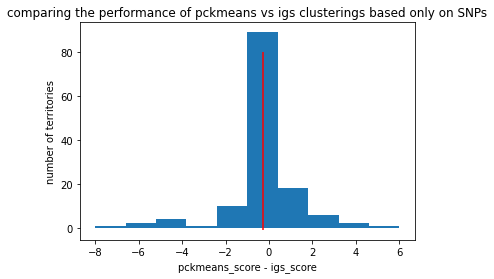

In [91]:
#ideally this is skewed towards the positive side
scores = np.array(scores)
# scores = scores[np.abs(scores)<50]
plt.hist(scores, align = 'mid')
plt.vlines([np.mean(scores)], ymin = -1, ymax = 80, color = 'red')
plt.ylabel("number of territories")
plt.xlabel("pckmeans_score - igs_score")
plt.title("comparing the performance of pckmeans vs igs clusterings based only on SNPs")

In [84]:
np.mean(scores)


-0.291044776119403

In [75]:
igs_mat = np.array([[1,2],
          [4,6]])
print(igs_mat)
find_sum_of_off_diagonal(igs_mat)

[[1 2]
 [4 6]]


array([1, 2])

In [79]:
def find_sum_of_off_diagonal(mat):
    if len(np.where(mat==0)[0])==3: #if the matrix has 3 zeros, then the one non-zero element is a diagonal one
        return 0
    elif len(np.where(mat==0)[0])==2: #if we have two zeros
        if (mat[0,1] == mat[1,0] ==0) or (mat[0,0] == mat[1,1] ==0): #if the two zeros are on opposite sides, we're gucci
            return 0
        else:
            return np.min(mat[mat!=0]) #assuming that the smaller non-zero number is the 'off-diagonal' one
    elif len(np.where(mat==0)[0])==1:  #if there's only one zero, the off_diagonal one is the one opposite to the zero
        i, j  = np.where(mat==0)[0][0], np.where(mat==0)[1][0]
        return mat[1-i, 1-j]
    else: #we have no zeros
        return np.sum(np.sort(mat.flatten())[0:2]) #the sum of the least two numbers
    
    
    
    

In [69]:
igs_mat.flatten()

array([1, 2, 4, 6])